In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import glob
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from wordcloud import WordCloud



In [9]:
# Load the dataset with low_memory=False to avoid the DtypeWarning
file_path = 'med_dataset_cleaned.csv'
medicine_data = pd.read_csv(file_path, low_memory=False)
medicine_data.head()


,id,name,substitute0,substitute1,sideEffect0,sideEffect1,sideEffect2,sideEffect3,sideEffect4,use0,use1,use2
0,1,augmentin 625 duo tablet,Penciclav 500 mg/125 mg Tablet,Moxikind-CV 625 Tablet,Vomiting,Nausea,Diarrhea,N,N,Treatment of Bacterial infections,N,N
1,2,azithral 500 tablet,Zithrocare 500mg Tablet,Azax 500 Tablet,Vomiting,Nausea,Abdominal pain,Diarrhea,N,Treatment of Bacterial infections,N,N
2,3,ascoril ls syrup,Solvin LS Syrup,Ambrodil-LX Syrup,Nausea,Vomiting,Diarrhea,Upset stomach,Stomach pain,Treatment of Cough with mucus,N,N
3,5,avil 25 tablet,Eralet 25mg Tablet,N,Sleepiness,Dryness in mouth,N,N,N,Treatment of Allergic conditions,N,N
4,6,allegra-m tablet,Emlukast-FX Tablet,LCFEX-Mont Tablet,Nausea,Diarrhea,Vomiting,Skin rash,Flu-like symptoms,Treatment of Sneezing and runny nose due to al...,N,N


Step 1: Data Preparation

In [10]:
# Clean text data
def clean_text(text):
    return text.lower().replace('_', ' ')

text_columns = ['name', 'use0', 'use1']

for col in text_columns:
    medicine_data[col] = medicine_data[col].apply(clean_text)

medicine_data['combined_text'] = medicine_data[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Further reduce the number of features
X = vectorizer.fit_transform(medicine_data['combined_text'])
y = medicine_data['name']

# Fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Encode the target labels
y_encoded = label_encoder.transform(y)

# Verify that the encoded labels are within the valid range
print(f"Labels range: {y_encoded.min()} to {y_encoded.max()}")


Labels range: 0 to 199127


Step 2: Define the Patient Questionnaire Function

In [11]:
def collect_patient_data():
    patient_data = {
        'primary_reason': input("What is your primary reason for seeking medication? "),
        'allergies': input("Do you have any known allergies or sensitivities to medications? "),
        'current_medications': input("Are you currently taking any other medications (prescription, over-the-counter, supplements)? "),
        'adverse_reactions': input("Have you had any adverse reactions to medications in the past? If so, please describe. "),
        'symptoms': input("Can you describe your symptoms in detail? When did they start? ")
    }
    return patient_data

Step 3: Collect Patient Data and Feature Engineering

In [12]:
# Collect patient data
patient_data = collect_patient_data()

# Convert patient data to DataFrame for easy manipulation
patient_df = pd.DataFrame([patient_data])

# Process text data (e.g., combine all text fields into one column)
text_fields = ['primary_reason']

# Combine text fields into a single feature for vectorization
patient_df['combined_text'] = patient_df[text_fields].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Vectorize the patient's text data
patient_vector = vectorizer.transform(patient_df['combined_text'])




Step 4: Medicine Recommendation

In [13]:

# Calculate the cosine similarity between the patient vector and medication vectors
similarities = cosine_similarity(patient_vector, X)

# Find the index of the medication with the highest similarity
best_match_index = similarities.argmax()

# Get the recommended medicine name
recommended_medicine = medicine_data.iloc[best_match_index]['name']
print(f"Recommended Medicine: {recommended_medicine}")


Recommended Medicine: augmentin 625 duo tablet


Step 5: Visualizations

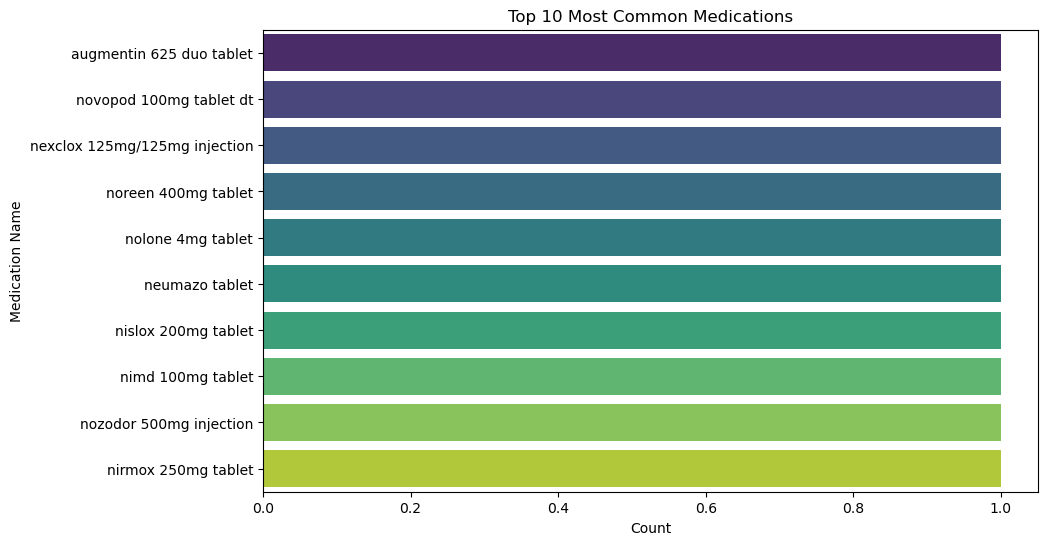

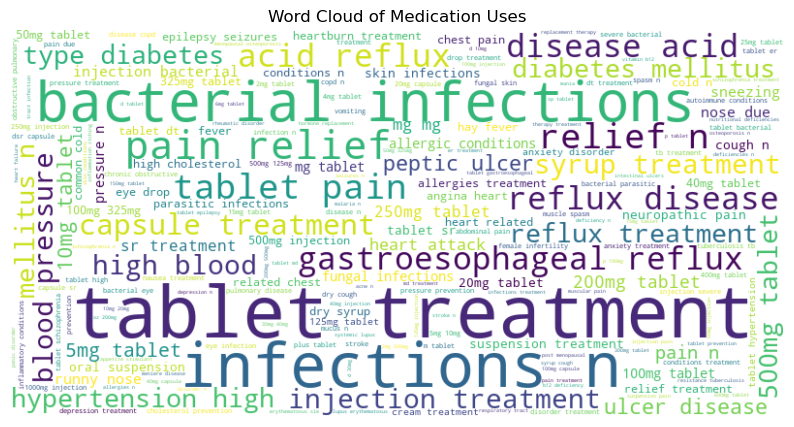

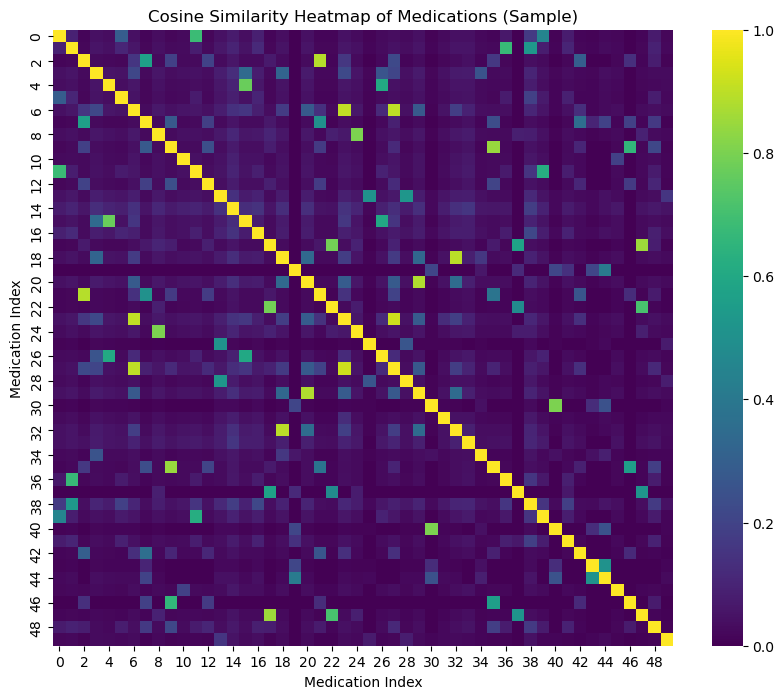

c:\Users\vhing\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


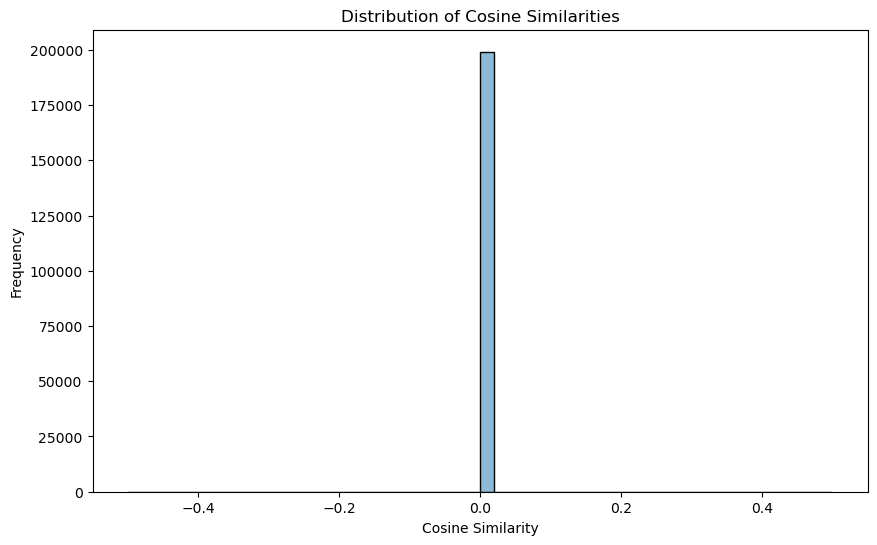

In [14]:
# 1. Bar plot of the top 10 most common medications
top_10_meds = medicine_data['name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_meds.values, y=top_10_meds.index, palette='viridis')
plt.title('Top 10 Most Common Medications')
plt.xlabel('Count')
plt.ylabel('Medication Name')
plt.show()

# 2. Word Cloud of medication uses
use_text = ' '.join(medicine_data['combined_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(use_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Medication Uses')
plt.axis('off')
plt.show()

# 3. Cosine similarity heatmap for a sample
sample_size = 50  # Adjust this for visualization purposes
X_sample = X[:sample_size]
similarity_matrix_sample = cosine_similarity(X_sample)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_sample, cmap='viridis')
plt.title('Cosine Similarity Heatmap of Medications (Sample)')
plt.xlabel('Medication Index')
plt.ylabel('Medication Index')
plt.show()

# 4. Distribution of cosine similarities for the recommended medication
plt.figure(figsize=(10, 6))
sns.histplot(similarities.flatten(), bins=50, kde=True)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()
